# Mini Weka
**Disciplina: ICC204 – 'Aprendizagem de Máquina e Mineração de Dados'
Prof. Rafael Giusti (rgiusti@icomp.ufam.edu.br)**

**Objetivo**: 
    Implementar o Mini Weka, contendo seus próprios algoritmos para induzir e
empregar os modelos de classificação estudados em aula.

**Formato de entrada**: 

Os indutores e classificadores devem leem arquivos de dados no formato **ARFF**, como abaixo. 
```js
    @RELATION weather

    @ATTRIBUTE outlook {sunny, overcast, rainy}
    @ATTRIBUTE temperature REAL
    @ATTRIBUTE humidity REAL
    @ATTRIBUTE windy {TRUE, FALSE}
    @ATTRIBUTE play {yes, no}

    @DATA
    sunny,85.0,85.0,FALSE,no
    sunny,80.0,90.0,TRUE,no
    overcast,83.0,86.0,FALSE,yes
    rainy,70.0,96.0,FALSE,yes
    rainy,68.0,80.0,FALSE,yes
    rainy,65.0,70.0,TRUE,no
    ...
    %
    %
    %
```

Os classificadores aceitam arquivos que representam os modelos induzidos, isto será feito através do [*Pickles*](https://www.geeksforgeeks.org/saving-a-machine-learning-model/) para salvar e carregar nossos modelos.

## Indutores implementados
Serão ser implementados indutores para as seguintes classes de modelos:
- [Modelo probabilístico Naive Bayes](#modelo-probabilístico-naive-bayes);
- [Árvores de decisão](#árvores-de-decisão);
- [Regras](#regras);
- [Modelo de Vizinhaça K-Nearest Neighbor](#vizinhaça);

## Base de dados
Para testar e validar nossos modelos, usaremos bases de dados, com atributos numéricos e com atributos nominais categórigos.
As bases podem ser encontradas no [Weka Data Sets](https://storm.cis.fordham.edu/~gweiss/data-mining/datasets.html).
Como exemplo inicial, usaremos o conjunto de dados Iris

In [154]:
# Para ler e visualizar os dados usaremos o scipy e pandas
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff
import warnings
warnings.filterwarnings('ignore')

### Iris dataset
Este talvez seja o banco de dados mais conhecido dentro de reconhecimento de padrões. O conjunto de dados contém 3 classes de 50 instâncias cada, onde cada classe se refere a um tipo de planta da íris. Uma classe é linearmente separável das outras duas, estas últimas não são entre si

In [157]:
data, info = loadarff('./data/iris.arff')
data = (pd.DataFrame(data)).apply(lambda x: x.apply(lambda s: s.decode("utf-8")) if type(x[0])==bytes else x)
print(info)
data.sample(5)

Dataset: iris
	sepallength's type is numeric
	sepalwidth's type is numeric
	petallength's type is numeric
	petalwidth's type is numeric
	class's type is nominal, range is ('setosa', 'versicolor', 'virginica')



,sepallength,sepalwidth,petallength,petalwidth,class
71,6.1,2.8,4.0,1.3,versicolor
31,5.4,3.4,1.5,0.4,setosa
53,5.5,2.3,4.0,1.3,versicolor
36,5.5,3.5,1.3,0.2,setosa
84,5.4,3.0,4.5,1.5,versicolor


In [3]:
iris = data

## Visualização dos dados

Antes de iniciar qualquer trabalho em cima dos conjuntos de dados, é importante conhecer bem os mesmos. Usar gráficos e diagramas para visualizar grandes quantidades de dados complexos torna mais fácil compreender como os dados estão distribuídos ou identificar novos padrões. Este conhecimento nos ajuda a tomar decisões de projetos enquanto construímos nosso modelo

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

### Iris plot
Quando não sabemos por onde começar, podemos sempre tentar plotar os atributos em pares, assim obtemos uma visão geral do conjunto

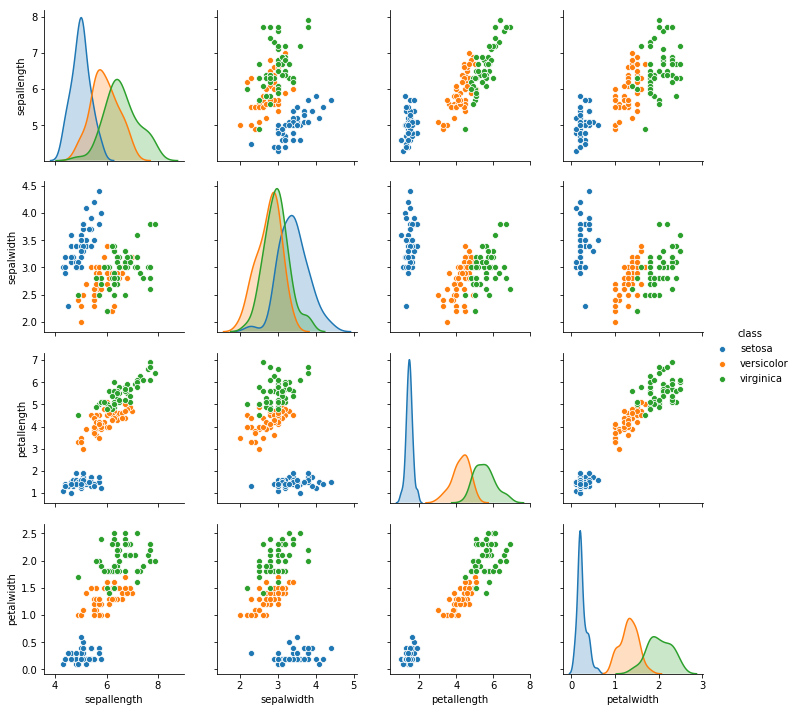

In [5]:
sns.pairplot(iris, hue='class', markers='o')
plt.show()

E analisando o grafico, percebe-se que os atributos 'petallength' e 'petalwidth' representam melhor as amostras ao separar de forma mais precisa as espécies de Iris.
Apesar da visualisação simples apresentada acima, é o suficiente para observar de forma tímida como e quanto os atributos infuenciam a classe alvo

## Classe Base para Modelos com distribuição Gausiana

Esta Classe serve de base para preparar os dados antes de usar os modelos. No caso além de algumas verificações, a função __check_X_y__ mapeia os atributos categóricos numa sequencia de numeros inteiros, a começar pelo zero e em diante, assim, permitindo os modelos trabalharem apenas com uma distribuição Gausiana para com todos os atributos

In [6]:
from sklearn.preprocessing import LabelEncoder
class GaussianBase(object):
    def __init__(self):
        self.n_feature = None
        
    def check_X_y(self, X, y=None, reset=False):
        n_samples, n_feature = X.shape
        
        if(y is not None and n_samples != len(y)):  raise Exception('Numero diferente de dados e rótulos das amotras')
        if(reset):
            self.n_feature = n_feature
            self.feature_label_encoder = [None for i in range(n_feature)]
        if(self.n_feature is None): raise Exception('Tente treinar o modelo primeiro')
        elif(self.n_feature != n_feature): raise Exception('Número de atributos difere do cedido anteriomente: {n_feature} ao invés de {self.n_feature}')
        
        feature_label_encoder = self.feature_label_encoder
        for i in range(n_feature):
            try:
                float(X[0,i])
            except:
                if(feature_label_encoder[i]==None):
                    feature_label_encoder[i] = LabelEncoder()
                    feature_label_encoder[i].fit(X[:, i])
                X[:, i] = feature_label_encoder[i].transform(X[:,i])
                
        self.n_samples = n_samples
        self.n_feature = n_feature
        self.feature_label_encoder = feature_label_encoder
                
        return X,y

##  Modelo probabilístico Naive Bayes<a name="modelo-probabilístico-naive-bayes"></a>

O Naive Bayes é um classificador probabilístico simples baseado no teorema de Bayes. O teorema de Bayes descreve a probabilidade de um evento, com base no conhecimento prévio de condições que podem estar relacionadas ao evento. Por exemplo, se o alzheimer está relacionado à idade, então, usando o teorema de Bayes, a idade de uma pessoa pode ser usada para avaliar com mais precisão a probabilidade de alzheimer, comparada com a avaliação da probabilidade sem conhecimento da idade da pessoa.

O teorema de Bayes é declarado matematicamente como a seguinte equação:

$$
    P(A\mid B) = \frac{P(B\mid A)P(A)}{P(B)}
$$

onde $A$ e $B$ são eventos e $P(B)\neq 0$.
- $P(A\mid B)$  é uma probabilidade condicional: a probabilidade do evento $A$ ocorrer dado que $B$ é verdadeiro.
- $P(B\mid A)$ também é uma probabilidade condicional: a probabilidade de evento $B$ ocorrer dado que $A$ é verdadeiro.
- $P(A)$ e $P(B)$ são as probabilidades de observar $A$ e $B$ independentemente uns dos outros; isso é conhecido como a probabilidade marginal.

Este indutor é chamado de ingênuo pois assume que todos os atributos são independentes entre si:

$$
    f_{nb}(X) = argmax_{c_{j} \in \Omega} = \begin{Bmatrix} p(c_{j})\prod_{i=1}^{M}p(x_{i}\mid c_{j})\end{Bmatrix}
$$

Os parâmetros do modelo são simplesmente as probabilidades posteriores $p(x_{i}\mid c_{j})$ e as
probabilidades a priori $p(c_{j})$, onde $c$ são a classes do conjunto. 

A diferença entre as diversas variações do Naive Bayes é como o modelo interpreta as probabilidades.

### Gaussian Naive Bayes

Neste Naive Bayes, assume-se que as probabilidade dos dados são uma distribuição Gaussiana, o que é ótimo para dados contínuos:

$$
    P(x_i \mid c) = \frac{1}{\sqrt{2\pi\sigma^2_c}} \exp\left(-\frac{(x_i - \mu_c)^2}{2\sigma^2_c}\right)
$$

Os parametros $\sigma_c$ e $\mu_c$, neste contexto, são consecutivamente o desvio padrão e a média dos atributos das amostras separadas por classe. 

Escolhemos esta variação pois transformar os atributos nominais categóricos em numérios contínuos tem baixo custo, assim trabalhamos com ambos os tipos sem muita dificuldade.

A partir deste ponto, seguimos os dois passos abaixo:
- Treinamento: calcular e armazenar os valores de probabilidades
- Classificação de um novo exemplo: calcular as probabilidades para os atributos e classes relevante e escolher o argumento (classe) que maximiza a probabilidade posterior

In [141]:
import math

class NaiveBayes(GaussianBase):
    
    def __init__(self):
        super().__init__()
        self.__name__ = "NaiveBayes"
    
    def calculate_probability(self, x, mean, stdev):
        return (1 / (math.sqrt(2*math.pi) * stdev)) * math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    
    def calculate_class_probabilities(self, sample):
        probabilities = {}
        for class_value, class_summaries in self.summaries.items():
            probabilities[class_value] = 1
            for i in range(self.n_feature):
                mean, stdev = class_summaries[i]
                x = sample[i]
                probabilities[class_value] *= self.calculate_probability(x, mean, stdev)
        return probabilities
    
    def separate_by_class(self, X, y):
        return { c : X[y==c] for c in np.unique(y) }
    
    def summarize(self, instances):
        return [ (np.mean(instances[:,i]), np.std(instances[:,i])) for i in range(self.n_feature)]
        
    def fit(self, X, y):
        
        X,y = self.check_X_y(X,y, reset=True)
        separated = self.separate_by_class(X, y)
        
        summaries = {}
        for classValue, instances in separated.items():
            summaries[classValue] = self.summarize(instances)
            
        self.summaries = summaries
    
    def _predict(self, sample):
        probabilities = self.calculate_class_probabilities(sample)
        best_label, best_prob = None, -1
        for class_value, probability in probabilities.items():
            if best_label is None or probability > best_prob:
                best_prob = probability
                best_label = class_value
        return best_label
    
    def predict(self, X):
        X,_ = self.check_X_y(X)
        return np.array([ self._predict(sample) for sample in X])


## Árvores de decisão <a name="árvores-de-decisão"></a>

Árvores de decisão são métodos de aprendizado de máquinas supervisionado não-paramétricos, muito utilizados em tarefas de classificação e regressão.

Mas de modo geral, são estruturas de dados formadas por um conjunto de elementos chamados nós, nele são guardado informaões. Além disso, toda árvore possui um nó chamado raiz, que seria o ponto de partida e ligações para outros elementos, denominados nós filhos. Esses filhos podem possuir seus próprios filhos e assim por diante. O nó que não possui filho é conhecido como nó folha. Dessa forma, uma árvore de decisão armazena regras em seus nós, e os nós folhas representam a decisão a ser tomada.

Um exemplo de árvore de decisão seria como abaixo:
<div style="text-align:center">
    <img style="width:40%;
                height: auto"
         src="./img/decision_tree.png" />
</div>

A ideia geral de métodos baseados em árvores é particionar o espaço recursivamente em retângulos (sub-regiões), nos quais um modelo simples é aprendido.
O espaço pode ser particionado de forma manual, mas a apredizagem de maquina se dá ao encontrar os melhores pontos de corte do espaço de forma automática.
Fazemos isso usando medidas de impureza, tal como Gini Index, Entropia ou taxa de erro.

Como encontrar o ponto de corte que leva a árvore de decisão ótima pode ser computacionalmente inviável, nós nos contentamos em fazer escolhas locais ótimas para encontrar o melhor atributo utilizado para o particionamento e a cada iteração nosso modelo vai separar melhor os dados.

### Calculando o ganho de informação
O ganho de informação, de grosso modo, representa a informação aprendida sobre as amostras quando dividimos uma região do espaço em duas sub-regiões de acordo com ponto de corte. E é definida pela fórmula:

$$
InfoGain(R, R_e, R_d) = H(R) - \frac{|R_e|\cdot H(R_e) + |R_d|\cdot H(R_d)}{|R|}
$$

onde $H$ é a impureza da região, $R$ é a região atual, $R_e$ é sub-região da esquerda, $R_d$ é sub-região da direita e $| \cdot |$ é quantidade de exemplos na dada região. Os critérios de impureza mais comuns para classificação são a Entropia e o índice Gini, definidos a seguir:

$$
entropia(R) = -∑ p(c|R)\cdot log (p(c|R)) ,
$$
<br>
$$
gini(R) = ∑ p(c|R)\cdot (1 - p(c|R)),
$$

onde $p(c|R)$ é a probabilidade de um ponto da região $R$ pertencer a classe $c$. Essa probabilidade é estimada pela razão entre quantidade de pontos da classe $c$ e o total de pontos em $R$.

Continuamos a reparticionar o espaço até atingir uma profundidade máxima preestabelecida ou se a região é pura

A partir deste ponto, seguimos os dois passos abaixo:
- Treinamento: construir a árvore de acordo com o modelo descrito acima, reparticionando o espaço das amostras
- Classificação de um novo exemplo: percorrer a árvore até um nó folha de acordo com as regras criadas em cada repartição

In [142]:
from sklearn.preprocessing import LabelEncoder

class Node(object):
    def __init__(self, feature=None, threshold=None,
                     is_leaf=None, counts=None, left=None, right=None):
        super(Node, self).__init__()
        self.threshold = threshold
        self.is_leaf = is_leaf
        self.counts = counts
        self.left = left
        self.right = right
        self.feature = feature

class DecisionTree(object):
    
    def __init__(self, max_depth, impurity_criterion = "gini"):
        super(DecisionTree, self).__init__()
        impurities_criterion = {"gini": self.gini, "entropy": self.entropy}
        self.max_depth = max_depth
        self.impurity_criterion = impurities_criterion[impurity_criterion]
        self.__name__ = "DecisionTree"
        
    def stopping_criterion(self, n_classes, depth, max_depth):
        return (max_depth is not None and max_depth == depth) or (n_classes == 1)
    
    def entropy(self, data, labels):
        classes = np.unique(labels)

        s = 0
        for c in classes:
            p = np.mean(labels == c)
            s -= p * np.log(p)

        return s


    def gini(self, data, labels):
        classes = np.unique(labels)

        s = 0
        for c in classes:
            p = np.mean(labels == c)
            s += p * (1 - p)

        return s
    
    def find_cut_point(self, data, labels, impurity_criterion = None):
        impurity_criterion = self.impurity_criterion
        n_samples, n_features = data.shape

        max_info_gain = np.iinfo(np.int32).min
        feat_id = 0
        best_threshold = 0

        # pré-calculando a impureza da região atual
        H_parent = impurity_criterion(data, labels)
        # para cada um dos atributos
        # vamos tentar encontrar o limiar que maximiza o ganho de informação
        for j in range(n_features):
        # só nos interessa os valores ordenados únicos 
        # do atributo j nessa região do espaço
            values = np.unique(data[:, j])

        for i in range(values.shape[0] - 1):
            # usamos o ponto médio dos valores possíveis
            # como limiar candidato para o ponto de corte
            threshold = (values[i] + values[i + 1]) / 2.

            mask = data[:, j] <= threshold

            info_gain = H_parent \
                      - (mask.sum() * impurity_criterion(data[mask], labels[mask]) \
                      + (~mask).sum() * impurity_criterion(data[~mask], labels[~mask])) \
                      / float(n_samples)

            if max_info_gain < info_gain:
                best_threshold = threshold
                feat_id = j
                max_info_gain = info_gain

        return feat_id, best_threshold
    
    def build_tree(self, data, labels, tree, depth = 1):
        classes, counts = np.unique(labels, return_counts=True)
        n_classes = classes.shape[0]

        # criétio de parada
        if not self.stopping_criterion(n_classes, depth, self.max_depth):
            node = Node()

            # encontra melhor ponto de corte dado a região atual do espaço
            # de acordo com critério de impureza escolhido
            feature, threshold = self.find_cut_point(data, labels, 
                                                tree.impurity_criterion)

            # aplicando o limiar para particionar o espaço
            mask = data[:, feature] <= threshold

            # contruindo árvore recursivamente para
            # os sub-espaço da direita e da esquerda.
            left = self.build_tree(data[mask], labels[mask], tree, depth + 1)
            right = self.build_tree(data[~mask], labels[~mask], tree, depth + 1)

            return Node(feature=feature, threshold=threshold, left=left, right=right)

        # calcula a quantidade de exemplos por classe nesse nó folha
        # e instancia um nó folha com essas quantidades, lembre-se que isso
        # será usado para predição. 
        values = np.zeros(self.n_classes)
        values[classes] = counts
        return Node(is_leaf=True, counts=values)
    
    def __recursive_predict(self, node, X):

        if node.is_leaf:
            return np.zeros(X.shape[0]) + np.argmax(node.counts)

        mask = X[:, node.feature] <= node.threshold

        y_pred = np.zeros(X.shape[0])
        if mask.sum() > 0:
            y_pred[mask] = self.__recursive_predict(node.left, X[mask])

        if (~mask).sum() > 0:
            y_pred[~mask] = self.__recursive_predict(node.right, X[~mask])

        return y_pred

    def fit(self, X, y):
        
        target_label_encoder = LabelEncoder()
        target_label_encoder.fit(y)
        y = target_label_encoder.transform(y)
        
        self.target_label_encoder = target_label_encoder
        self.classes = np.unique(y)
        self.n_classes = self.classes.shape[0]

        self.root = self.build_tree(X, y, self)

        return self

    def predict(self, X):
        y_predict = self.__recursive_predict(self.root, X)
        return np.array(self.target_label_encoder.inverse_transform(y_predict.astype(int)))

## Modelos baseados em Regras <a name="regras"></a>





São modelos que representam o conhecimento através de conjunções de condições, e são construídos em cima do próprio conjunto de informações. Esses modelos utilizam divisão e conquista para induzir regras em cima do conjunto de treinamento e criar uma coleção de conhecimentos que ajuda a tomar decisões.

O modelo é construído para tomar a coleção de treinamento como entrada e retornar uma série de regras que particionam o conjunto em relação a um rótulo que definem certas características.
Apesar de parecer bastante com arvores de decisões ( que podemos inclusive retirar regras de uma árvore de decisão dada!) temos algumas diferenças que distinguem esses modelos, que são a aproximação por cobertura, flexível quanto a cobertura e acurácia e modificação das regras.

### Métodos de Avaliação de Qualidade de Regras

Precisão – Mede o grau de especificidade de uma regra para um problema.

$$
Precisão(R) = \frac{Exemplos\;cobertos\;pelo\;corpo\;e\;pela\;cabeça\;da\;regra}{Exemplos\;cobertos\;pelo\;corpo\;da\;Regra}
$$

Acurácia - Mede o desempenho geral de uma regra.

$$
Acurácia(R) = Exemplos\;cobertos\;pelo\;corpo\;e\;pela\;cabeça\;da\;regra + Exemplos\;não\;cobertos\;pelo\;corpo,\;nem\;pela\;cabeça\;da\;regra.
$$

Utilizamos o algoritmo de Prism para indução modular de Regras.

A partir deste ponto, seguimos os dois passos abaixo:
- Treinamento: Enquanto houverem exemplos, não cobertos, ele construirá regras para cobrir exemplos.
- Classificação de um novo exemplo: Equanto o exemplo não satisfazer uma regra, o classificador escolhe uma regra e aplica, caso satisfaça a regra, ele rotarna a classe

In [143]:
class Rules(object):
    def __init__(self):
        self.rules = None
        self.__name__ = "Rules"
        
    #Transformando a base de dados numa lista dde dicionários para facilitar o treino
    def data_to_dicts(self, data):  
        D = []
        col = list(data.columns)
        for tp in data.values:
            d = {}
            for i in range(len(col)):
                d[col[i]] = tp[i]
            D.append(d)
        return D
    
    #Aplicando a regra na base de dados para descobrir quais tuplas são cobertas
    def apply_rule(self, data, R):
        coverage = data[:]
        for r in R:
            coverage = [i for i in coverage if i[r[0]] == r[1]]
        return coverage
    
    #Testando a precisão da regra
    def rule_accuracy(self, coverage, atr, cls):
        accuracy = [i for i in coverage if i[atr] == cls]
        return float(len(accuracy))/len(coverage), len(accuracy)
    
    #Escolhendo a melhor regra dentro de uma lista
    def get_best_rule(self, rules):
        rule = []
        best = []
        max_acc = 0
        max_cov = 0
        for r in rules:
            if r[2] > max_acc:
                max_acc = r[2]
                max_cov = r[3]
                best.append(r)
                
            elif r[2] == max_acc:
                if r[3] > max_cov:
                    best.append(r)
                    
        rule.append(best[-1])
        return rule
    
    #Construindo regras
    def build(self, instances, atrs, atr, cls):
        R = [] #Lista de regras
        accuracy = -1 #Precisão das regras geradas
        rule_instances = instances[::]  #Instâncias do anco de dados                             
        avail_attr = [a for a in atrs if a != atr] #Atributos a serem avaliados
        
        while True:
            all_rules = []
            #Para cada atributo ainda não utilizado:
            for A in [a for a in avail_attr if a not in [r[0] for r in R]]:
                #Para cada valor único deste atributo:
                for X in list(set([a[A] for a in rule_instances])):
                    
                    coverage = self.apply_rule(rule_instances, [[A, X]]) #Aplicar instância
                    accuracy = self.rule_accuracy(coverage, atr, cls) #Testar a precisão
                    all_rules.append([A, X, accuracy[0], accuracy[1]]) #Guardar regra
                    
            best = self.get_best_rule(all_rules) #Escolher a melhor regra gerada
            
            R.append((best[0][0], best[0][1])) #Guardar a melhor regra
            
            rule_instances = self.apply_rule(rule_instances, R) #Trocar as instâncias para melhorar a regra
            
            #Se a precisão chegar a 100% ou a regra cobrir menos de uma instância
            if best[0][2] == 1.0 or best[0][3] < 1: 
                break
            
        return R, rule_instances
        
    #Treinar o modelo
    def fit(self, X,y, atribute=None):
        data = np.append(X,[[sample] for sample in y], axis = 1)
        data = pd.DataFrame.from_dict({str(i):data[:,i] for i in range(len(data[0]))})
        if atribute is None: #Se nenhum atributo foi especificado, escolher o último
            atribute = data.columns[-1]
            
        self.atribute = atribute #Guardado o atributo de treinamento
        dicts = self.data_to_dicts(data) #Gerando dicionários
        atributes = list(data.columns) #Listando os atributos
        self.order = atributes #Guardando a lista dos atributos para fazer predições
        classes = list(set(data[atribute])) #Listando as classes
        self.rules = [] #Lista de regras
        
        #Escolhendo um atributo padão
        m = 0
        self.default = None
        for cls in classes:
            aux = len([i for i in list(data[atribute]) if i == cls])
            if aux > m:
                m = aux
                self.default = cls
        #Caso um exemplo não se enquadre em nenhuma regra, será classificado como parte da classe com mais exemplos
        
        #Para cada classe:
        for cls in classes:
            instances = dicts[::] 
            #Enquanto exestirem instâncias desta classe:
            while len([i for i in instances if i[atribute] == cls]) > 0:
                rule, covered = self.build(instances, atributes, atribute, cls) #Construir regra
                self.rules.append({cls:rule}) #Guardar regra
                instances = [i for i in instances if i not in covered] #Remover instâncias já cobertas
    
    #Escrever regras na tela
    def __str__(self):
        Rule = ""
        for rule in self.rules:
            k = list(rule.keys())[0]
            nbr = len(rule[k])        
            Rule += " if "
            for subrules in rule[k]:
                nbr -= 1
                Rule = Rule + str(subrules[0]) + " = " + subrules[1]
                if nbr > 0:
                    Rule = Rule + "\n\t and "
                else:
                    Rule = Rule + ":\n then " + self.atribute + " = " + k + "\n\n"
        
        return Rule +" else "+ self.default+"\n"
            
    #Função de predição
    def _predict(self, example):
        #Para cada regra:
        for rule in self.rules:
            cls = list(rule.keys())[0] #classe da regra
            flag = True #O exemplo pertence à classe cls
            #Para cada subregra:
            for subrules in rule[cls]:
                #Se o exemplo não obedece ela:
                if example[self.order.index(subrules[0])] != subrules[1]:
                    flag = False #O exemplo não pertence à cls
            #Se o exemplo pertence a cls:
            if flag:
                return cls
        
        #Caso um exemplo não se enquadre em nenhuma regra, será classificado como parte da classe com mais exemplos
        return self.default

    def predict(self, X):
        return np.array([ self._predict(list(sample)+['?']) for sample in X])

## Modelo de Vizinhaça K-Nearest Neighbor<a name="vizinhaça"></a>

A intuição por trás do K-Nearest Neighbor (KNN) é um dos mais simples de todos os algoritmos de aprendizado de máquina supervisionados. Ele simplesmente calcula a distância de um novo exemplo a todas as amostras de treinamento. A distância pode ser de qualquer tipo, por exemplo, Euclidean ou Manhattan etc. Em seguida, seleciona as K amostras mais próximas, em que K pode ser qualquer número inteiro. Finalmente, ele atribui o exemplo à classe à qual a maioria das K amostras pertence.

<br>
<div style="text-align:center">
    <img style="width:20%;
                height: auto"
         src="./img/knn3.png" />
</div>

### Euclidian

A distância euclidiana é a distância entre dois pontos, que pode ser provada pela aplicação repetida do teorema de Pitágoras

$$
D_{\rm {Euclidiana}}(x,y) = \sqrt {\sum _{i=1}^{n}(x_{i}-y_{i})^{2}}
$$

### Manhattan

De uma maneira mais formal, podemos definir a distância de Manhattan entre dois pontos num espaço euclidiano com um sistema cartesiano de coordenadas fixo como a soma dos comprimentos da projecção da linha que une os pontos com os eixos das coordenadas.

$$
D_{\rm {Manhattan}}(x,y) = \sum _{i=1}^{n}|x_{i}-y_{i}|
$$

### Chebyshev

Distância Chebyshev é uma métrica definida em um espaço vetorial onde a distância entre dois vetores é a maior de suas diferenças ao longo de qualquer dimensão de coordenada.

$$
D_{\rm {Chebyshev}}(x,y) = \max _{i}(|x_{i}-y_{i}|)
$$

A partir deste ponto, seguimos os dois passos abaixo:
- Treinamento: apenas guardar um grupo de amostras que servirão de referencia
- Classificação de um novo exemplo: calcular a classe mais frequente dos k vizinhos mais proximos

In [144]:
import numpy as np
from operator import itemgetter
from collections import Counter

class KnnClassifier(GaussianBase):
    def __init__(self, n_neighbors=5, distance="euclideana"):
        super().__init__()
        distances = {"euclideana":self.__euclideana, "manhattan":self.__manhattan, "chebyshev":self.__chebyshev}
        
        self.n_neighbors = n_neighbors
        self.__distance = distances[distance]
        self.__distances = distances
        self.__name__ = "KnnClassifier"
    
    def __euclideana(self, x, y):
        return sum((x - y)**2)**0.5
    
    def __manhattan(self, x, y):
        return sum(abs(x - y))
    
    def __chebyshev(self, x, y):
        return max(abs(x - y))
    
    def fit(self, X, y):
        X,y = self.check_X_y(X,y, reset=True)
        self.X, self.y = X,y
    
    def _predict(self, sample):
        neighbors_distances = list(map(lambda X,y: (self.__distance(sample,X),y), self.X, self.y))
        neighbors_distances.sort(key=itemgetter(0))
        neighbors_distances.append((np.Inf,-1))
        
        k_neighbors = []
        for i in range(len(neighbors_distances)):
            k_neighbors.append(neighbors_distances[i][1])
            if len(k_neighbors) >= self.n_neighbors and neighbors_distances[i][0] != neighbors_distances[i+1][0]:
                break
        
        mode_neighbors_end = Counter(k_neighbors[(self.n_neighbors-1):]).most_common(1)[0][0]
        mode_neighbors = Counter(k_neighbors[:(self.n_neighbors-1)] + [mode_neighbors_end]).most_common(1)[0][0]
        
        return mode_neighbors

    def predict(self, X):
        X,_ = self.check_X_y(X)
        return np.array([ self._predict(sample) for sample in X])


# Validação e Testes dos Modelos

## Stratified 10 Fold Cross-Validation

Para validar os modelos, usaremos uma validação cruzada e estratificada com 10 folds. Esta tecnica nos permetirá avaliar a capacidade de generalização dos modelos. O conceito central desta técnica de validação cruzada é o particionamento do conjunto de dados em 10 subconjuntos mutualmente exclusivos, e posteriormente, utiliza-se 9 destes subconjuntos para a estimação dos parâmetros do modelo (dados de treinamento) e 1 dos subconjuntos (dados de validação ou de teste) são empregados na validação do modelo. Este processo é realizado 10 vezes alternando de forma circular o subconjunto de teste. Dizemos também que este é estratificado pois os folds são feitos preservando a porcentagem de amostras para cada classe. Abaixo, o exemplo demostra o funcionamento da técnica para k folds.

<div style="text-align:center">
    <img style="width:40%;
                height: auto"
         src="./img/stratified_kfold.png" />
</div>

Ao final das 10 iterações calcula-se a acurácia sobre os erros encontrados obtendo assim uma medida mais confiável sobre a capacidade do modelo de representar o processo gerador dos dados. A precisão final do modelo estimado, aqui, será obtido por 3 metricas (precisão, revocação e F1) e uma matrix de confusão.

## Confusion Matrix

Vamos falar primeiro da matriz de confusão , também conhecida como uma matriz de erro, é um esquema tabela específica que permite a visualização do desempenho de um modelo. Cada linha da matriz representa as instâncias em uma classe prevista, enquanto cada coluna representa as instâncias em uma classe real (ou vice-versa). O nome deriva do fato de que é fácil ver se o sistema está confundindo duas classes (ou seja, rotulando erroneamente uma como outra).

<table class="wikitable" style="border:none; margin-top:0;">
    <tbody>
        <tr>
            <th style="background:white; border:none;" colspan="2" rowspan="2"></th>
            <th colspan="3" style="background:none;">
                <font style="vertical-align: inherit;">
                    <font style="vertical-align: inherit;">Classe real</font>
                </font>
            </th>
        </tr>
        <tr>
            <th>
                <font style="vertical-align: inherit;">
                    <font style="vertical-align: inherit;">Gato</font>
                </font>
            </th>
            <th>
                <font style="vertical-align: inherit;">
                    <font style="vertical-align: inherit;">Não gato</font>
                </font>
            </th>
        </tr>
        <tr>
            <th rowspan="3" style="height:6em;">
                <div style="display: inline-block; -ms-transform: rotate(-90deg); -webkit-transform: rotate(-90deg); transform: rotate(-90deg);;"><font style="vertical-align: inherit;">
                    </font>
                        <br>
                            <font style="vertical-align: inherit;">
                                <font style="vertical-align: inherit;">Classe </font>
                                <font style="vertical-align: inherit;">prevista</font>
                    </font>
                </div>
            </th>
            <th>
                <font style="vertical-align: inherit;">
                    <font style="vertical-align: inherit;">Gato</font>
                </font>
            </th>
            <td>
                <font style="vertical-align: inherit;">
                    <font style="vertical-align: inherit;">5 verdadeiros positivos</font>
                </font>
            </td>
            <td>
                <font style="vertical-align: inherit;">
                    <font style="vertical-align: inherit;">2 falsos positivos</font>
                </font>
            </td>
        </tr>
        <tr>
            <th>
                <font style="vertical-align: inherit;">
                    <font style="vertical-align: inherit;">Não gato</font>
                </font>
            </th>
            <td>
                <font style="vertical-align: inherit;">
                    <font style="vertical-align: inherit;">3 falsos negativos</font>
                </font>
            </td>
            <td>
                <font style="vertical-align: inherit;">
                    <font style="vertical-align: inherit;">17 verdadeiros negativos</font>
                </font>
            </td>
        </tr>
    </tbody>
</table>

## Precision e Recall

Precisão (também chamada de valor preditivo positivo) é a fração de amostras preditas corretamentes entre todas as predições desta classe, enquanto a Revocação (também conhecida como sensibilidade) é a fração de amostras preditas corretamente entre todas as amostras que de fato pertenciam a classe predita. Tanto a precisão quanto a Revocação são, portanto, baseadas em um entendimento e medida de relevância.

$$
Precision = \frac{Verdadeiros Positivos}{Verdadeiros Positivos + Falso Positivos}
$$
<br>
$$
Recall = \frac{Verdadeiros Positivos}{Verdadeiros Positivos + Falso Negativos}
$$

## $F_{1}$ score

A pontuação $F_{1}$ é a média harmônica da Precisão e da Revocação, em que atinge seu melhor valor em 1 (precisão e recordação perfeitas) e a pior em 0

$$
F_{1}=2\cdot {\frac {\mathrm {Precision} \cdot \mathrm {Recall} }{\mathrm {Precision} +\mathrm {Recall} }}
$$

In [187]:
import scipy.stats as stats
import statistics
from math import sqrt
from sklearn.metrics import recall_score, precision_score, f1_score,confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import check_X_y

def plot_confusion_matrix(cm, classes=None, title=None):
    
    if classes is None: classes = list(range(len(cm)))
    
    cm_normalize = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    fig.suptitle(title, y=1.1)
    
    data = [(pd.DataFrame(cm_, index=classes, columns=classes), title, ax) for cm_, title,ax in (
        (cm,'Confusion matrix, without normalization', ax1), 
        (cm_normalize, 'Normalized confusion matrix', ax2)
    )]

    sns.set(font_scale=1.4)
    for df, title, ax in data:
        sns.heatmap(df, annot=True,annot_kws={"size": 14}, ax=ax).set_title(title)
        
def plot_metric_value(metric_values, classes=None, title=None):
    
    metric_names = metric_values.keys()
    x_pos = np.arange(len(metric_names))
    size = len(x_pos)
    width = 0.27
    m = np.array([[float(metric_values[key][k][0]), float(metric_values[key][k][1])] for key in metric_values.keys() for k in metric_values[key]]).T
    rects = []
    c = ['r','b','g']
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    fig.suptitle("Dataset "+title, y=1.1, x=0.46)
    
    if classes is None: classes = x_pos
    
    for i in range(size):
        mean, erro = m[0][i*size:(i+1)*size], m[1][i*size:(i+1)*size]
        react = ax.bar(x_pos+i*width, mean, width, color=c[i], yerr=erro, align='center', alpha=0.5, ecolor='black', capsize=10)
        rects.append(react[0])
        
    ax.set_ylim((min(m[0])-min(m[1])-0.07, max(m[0])+max(m[1])+0.02))
    ax.set_xticks(x_pos+width)
    ax.set_xticklabels( tuple(classes) )
    ax.legend( tuple(rects), tuple(metric_names) )
    ax.yaxis.grid(True)
    
    plt.show()

        
def statistics_metric_value(metric_list, nTargets):
    mean_list = [0 for i in range(nTargets)]
    result = {i:[] for i in range(nTargets)}
    z_critical = stats.norm.ppf(q = 0.975)
    elements_class = []
    
    for i in range(0,len(mean_list)):
        for j in metric_list:
            mean_list[i] += j[i]
            elements_class.append(j[i])
            
        standard_dev = statistics.stdev(elements_class)
        margin_of_error = z_critical * (standard_dev/sqrt(len(elements_class)))
        confidence_interval = "{:4.4f}".format(margin_of_error)

        mean_list[i] = mean_list[i]/len(metric_list)
        result[i] = [mean_list[i],confidence_interval]

    return result
        
def crossValidationStratifiedKfold(classifier,X,y,n_splits=10):
    
    
    targets = unique_labels(y)
    n_targets = len(targets)
    stratified_fold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    precisions, recalls, f1s = [], [], []
    cm = [[0 for i in targets] for j in targets]
    
    
    for train_index, test_index in stratified_fold.split(X,y):
        X_train, X_test = X[train_index],X[test_index]
        y_train, y_test = y[train_index],y[test_index]
        
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test)
        cm += confusion_matrix(y_test, y_predict)
        precisions.append(precision_score(y_test, y_predict, average=None))
        recalls.append(recall_score(y_test, y_predict, average=None))
        f1s.append(f1_score(y_test, y_predict, average=None))
    
    return classifier, cm, { name: statistics_metric_value(metric, n_targets) for name,metric in [("Precision",precisions),("Recall",recalls),("F1",f1s)] }

def modelValidation(classifier, dataset_file):
    data, info = loadarff(dataset_file)
    data = (pd.DataFrame(data)).apply(lambda x: x.apply(lambda s: s.decode("utf-8")) if type(x[0])==bytes else x)
    
    X,y = data.iloc[:,:-1].values, data.iloc[:,-1].values
    classes = unique_labels(y)
    
    classifier, cm, metric_values = crossValidationStratifiedKfold(classifier, X, y)
    
    plot_confusion_matrix(cm, classes, title=classifier.__name__)
    plot_metric_value(metric_values, classes, title=info.name)
    
    return classifier

## Plot das validações para cada Modelo

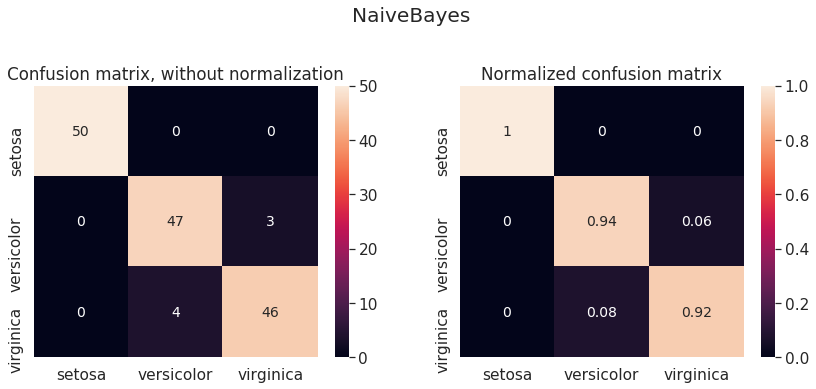

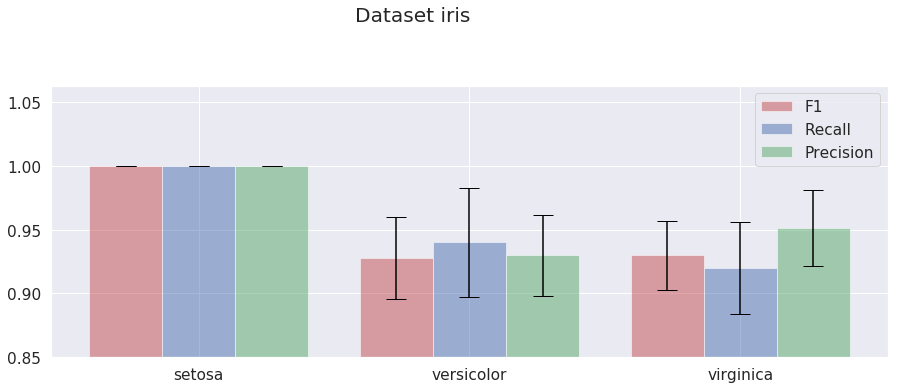

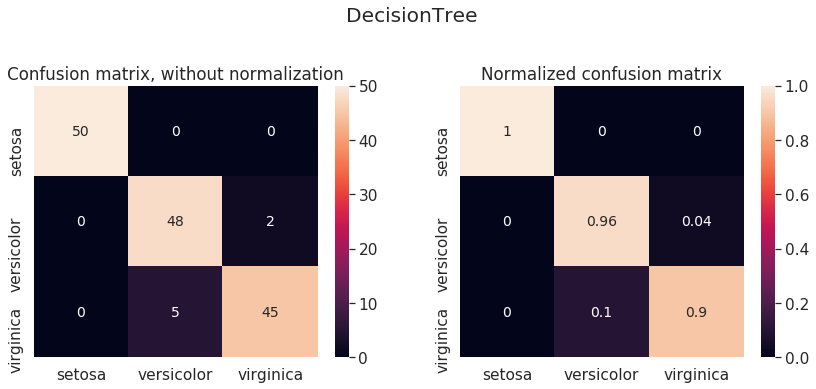

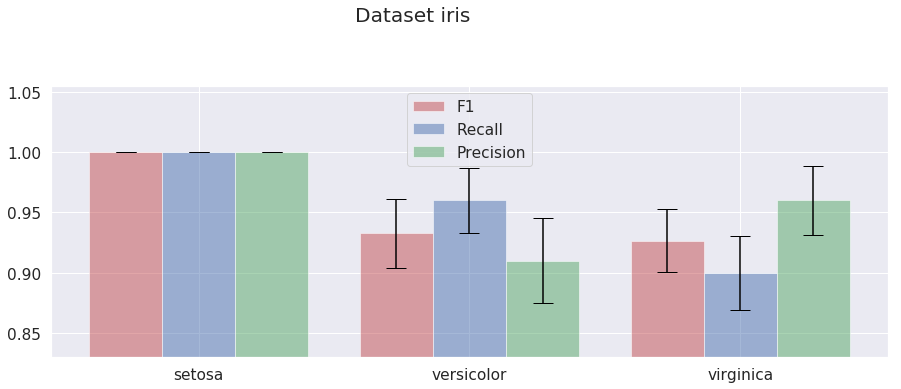

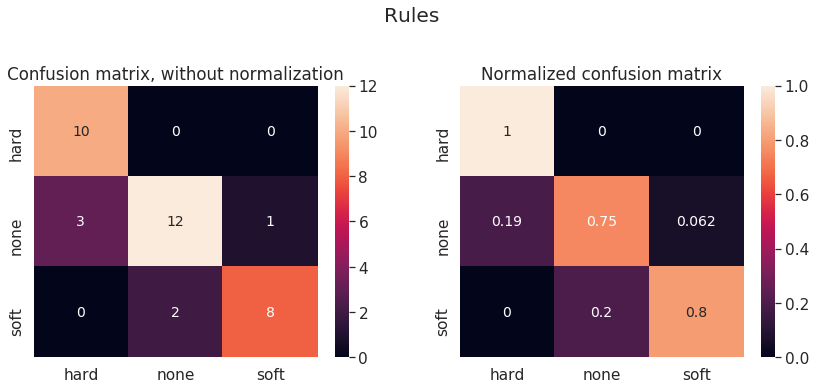

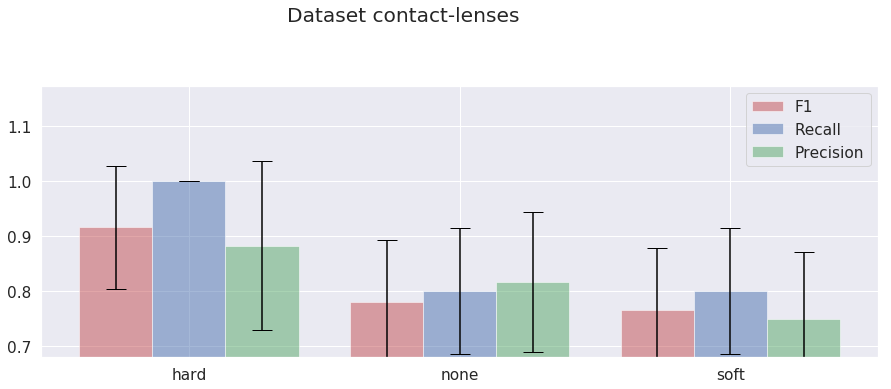

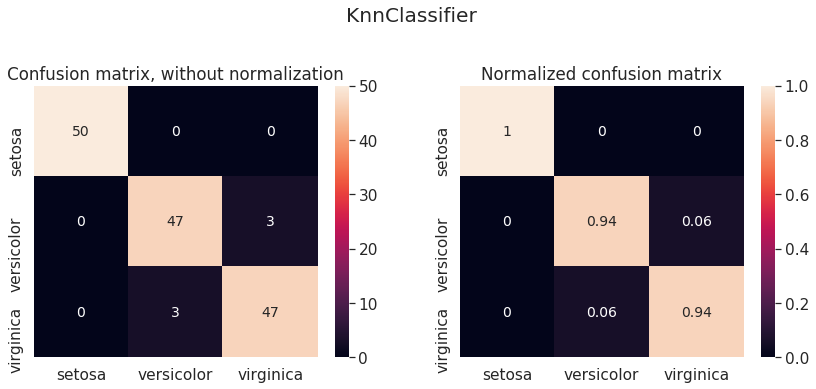

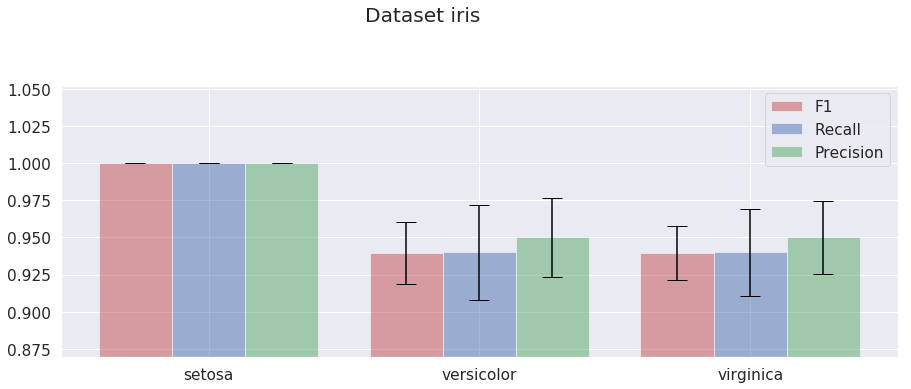

In [193]:
X,y = iris.iloc[:,:-1].values, iris.iloc[:,-1].values

models = [ 
    NaiveBayes(),
    DecisionTree(max_depth=4),
    Rules(),
    KnnClassifier(n_neighbors=3)
]

for i in range(len(models)):
    model = models[i]
    
    if model.__name__ !=  "Rules":
        model = modelValidation(model, './data/iris.arff')
    else:
        model = modelValidation(model, './data/contact-lenses.arff')
    
    models[i]=model
    


## Salvando os modelos treinados

In [173]:
import pickle

In [192]:
for model in models:
    pickle.dump(model, open('./models/'+model.__name__+".sav", 'wb'))

## Carregando modelos

In [194]:
import pickle

In [210]:
def load_model(model_path='./models/KnnClassifier.sav'):
    return pickle.load(open(model_path, 'rb'))

In [199]:
print(models)

[<__main__.NaiveBayes object at 0x7f70f01394a8>, <__main__.DecisionTree object at 0x7f70f32fd208>, <__main__.Rules object at 0x7f70ebf403c8>, <__main__.KnnClassifier object at 0x7f70f013fba8>]


In [212]:
knn = load_model()

EOFError: Ran out of input